In [1]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

# -----------------------------------------------------------------------------

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x, matching_indices_1st = None, matching_indices_2nd = None):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if matching_indices_1st is not None and matching_indices_2nd is not None:
            k[:, :, matching_indices_2nd, :] = k[:, :, matching_indices_1st, :]
            q[:, :, matching_indices_2nd, :] = q[:, :, matching_indices_1st, :]
            v[:, :, matching_indices_2nd, :] = v[:, :, matching_indices_1st, :]


        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x, matching_indices_1st = None, matching_indices_2nd = None):
        x = x + self.attn(self.ln_1(x), matching_indices_1st, matching_indices_2nd)
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, matching_indices_1st = None, matching_indices_2nd = None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x, matching_indices_1st, matching_indices_2nd)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [2]:
# # -----------------------------------------------------------------------------
# num_return_sequences = 5
# max_length = 30

# model_name = 'gpt2-large'

# model = GPT.from_pretrained(model_name)                   
# model.eval()
# model.to('cuda')

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the GPT-2 XL tokenizer and model
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/home/longnhat/miniconda3/envs/icl_mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load data
from datasets import load_from_disk
from tqdm import tqdm

# Load the dataset from disk
subset = load_from_disk("english_insertions")

prompt_list = []
base_sents = subset['train']['base_sentence']
phrases = subset['train']['phrase']
edited_sents = subset['train']['edited_sentence']

In [5]:
import string
from tqdm import tqdm
import numpy as np

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

def preprocessing(text):
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Remove multiple whitespaces
    text = ' '.join(text.split())
    return text

# function to calculate jaccard of two sets
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union

# def encode_decode(text, cuda = False, return_ids = False):
#     input_ids = enc.encode(text)
#     input_ids = torch.tensor(input_ids, dtype=torch.long) # (n,)
#     input_ids = input_ids.unsqueeze(0) # (1, n)
#     if cuda:
#         input_ids = input_ids.to('cuda')

#     tokens = input_ids[0].tolist()
#     decoded_tokens = [enc.decode([token]) for token in tokens]

#     if return_ids:
#         return decoded_tokens, input_ids
#     else:   
#         return decoded_tokens

def encode_decode(text, cuda = False, return_ids = False):
    if cuda:
        input_ids = tokenizer.encode(text, return_tensors='pt').to(device)
    else:
        input_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = input_ids[0].tolist()
    decoded_tokens = [tokenizer.decode([token]) for token in tokens]

    if return_ids:
        return decoded_tokens, input_ids
    else:   
        return decoded_tokens

def is_punctuation(token):
    # Consider tokens that are punctuation marks or empty spaces
    return token.strip() in string.punctuation or token.strip() == '' or token.strip() == '\n'

def get_tokens_without_punctuation(tokens):
    tokens_no_punct = []
    indices = []
    for idx, token in enumerate(tokens):
        if not is_punctuation(token):
            tokens_no_punct.append(token)
            indices.append(idx)
    return tokens_no_punct, indices

def find_token_indices(base_tokens, edited_tokens, base_indices, edited_indices):
    matching_indices = []
    edited_pos = 0
    for base_idx, base_token in zip(base_indices, base_tokens):
        found = False
        base_token_stripped = base_token.strip()
        while edited_pos < len(edited_tokens):
            edited_token_stripped = edited_tokens[edited_pos].strip()
            if base_token_stripped == edited_token_stripped:
                matching_indices.append(edited_indices[edited_pos])
                edited_pos += 1
                found = True
                break
            else:
                edited_pos += 1
        if not found:
            return False
    return matching_indices

def find_base_sent(base_sent, prompt):
    base_sentence = encode_decode(base_sent)
    edited_sentence, edited_ids = encode_decode(prompt, cuda=True, return_ids=True)

    # print(f"base: {base_sentence}")
    # print(f"edited: {edited_sentence}")

    # Get tokens and indices without punctuation from base sentence
    base_tokens_no_punct, base_indices_no_punct = get_tokens_without_punctuation(base_sentence)

    idx = len(base_sentence) + 4
    realign_edited_sentence = edited_sentence[:idx]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_1st = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    idx = len(base_sentence) + 3
    realign_edited_sentence = edited_sentence[idx:]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_2nd = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    if matching_indices_1st == False or matching_indices_2nd == False:
        return False, False, False, False

    # add idx to the indices 2nd
    matching_indices_2nd = [i + idx for i in matching_indices_2nd]

    return matching_indices_1st, matching_indices_2nd, edited_ids, edited_sentence

In [6]:
import torch
import numpy as np
from tqdm import tqdm

def get_top_k(logits, top_k, tokenizer):
    prob = torch.softmax(logits, dim=-1)
    top_tokens = torch.topk(prob, top_k, dim=-1)
    tokens = [tokenizer.decode([idx.item()]) for idx in top_tokens.indices[0]]
    return tokens

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

n = 5    # For n=1, should closely resemble Code A's behavior
skiped = 0
top_k = 10

model_names = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
jc_lists = []
acc_lists = []

for model_name in model_names:
    print(model_name)
    # Load the tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT.from_pretrained(model_name)                   
    model.eval()
    model.to('cuda')

    jc_ult = []
    first_pred_ult = []

    for i in tqdm(range(1000)):
        base_sent = preprocessing(base_sents[i])
        phrase = preprocessing(phrases[i])
        edited_sent = preprocessing(edited_sents[i])

        prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

        # Find indices in edited sentence
        matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = find_base_sent(base_sent, prompt)
        if matching_indices_1st == False or matching_indices_2nd == False:
            skiped += 1
            continue

        # Prepare dictionary for predictions:
        # Each step will have its own dictionary: {'adjusted': [...], 'original': [...]}
        dict_pred = {step: {} for step in range(n)}

        # Run adjusted model generation
        adjusted_generated_ids = input_ids.clone()
        for step in range(n):
            with torch.no_grad():
                outputs_adjusted = model(adjusted_generated_ids, 
                                        matching_indices_1st = matching_indices_1st, 
                                        matching_indices_2nd = matching_indices_2nd)
                next_token_logits_adjusted = outputs_adjusted[:, -1, :]
                adjusted_tokens = get_top_k(next_token_logits_adjusted, top_k, tokenizer)

            dict_pred[step]['adjusted'] = adjusted_tokens

            # Greedy decoding for next token
            next_token_id_adjusted = torch.argmax(next_token_logits_adjusted, dim=-1, keepdim=True)
            adjusted_generated_ids = torch.cat([adjusted_generated_ids, next_token_id_adjusted], dim=-1)

        # Run original model generation (no hooks)
        original_generated_ids = input_ids.clone()
        for step in range(n):
            with torch.no_grad():
                outputs_original = model(original_generated_ids)
                next_token_logits_original = outputs_original[:, -1, :]
                original_tokens = get_top_k(next_token_logits_original, top_k, tokenizer)

            dict_pred[step]['original'] = original_tokens

            # Greedy decoding for next token
            next_token_id_original = torch.argmax(next_token_logits_original, dim=-1, keepdim=True)
            original_generated_ids = torch.cat([original_generated_ids, next_token_id_original], dim=-1)

        # Compute metrics for each token step
        jc_scores = []
        first_predictions = []
        for step in range(n):
            adjusted_tokens = dict_pred[step]['adjusted']
            original_tokens = dict_pred[step]['original']
            jaccard_sim = jaccard_similarity(adjusted_tokens, original_tokens)
            jc_scores.append(jaccard_sim)
            first_predictions.append(int(adjusted_tokens[0] == original_tokens[0]))

        jc_ult.append(jc_scores)
        first_pred_ult.append(first_predictions)
    
    jc_lists.append(jc_ult)
    acc_lists.append(first_pred_ult)


gpt2


/home/longnhat/miniconda3/envs/icl_mi/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


loading weights from pretrained gpt: gpt2


100%|██████████| 1000/1000 [00:33<00:00, 29.97it/s]


gpt2-medium
loading weights from pretrained gpt: gpt2-medium


100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


gpt2-large
loading weights from pretrained gpt: gpt2-large


100%|██████████| 1000/1000 [02:30<00:00,  6.64it/s]


gpt2-xl
loading weights from pretrained gpt: gpt2-xl


100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


In [48]:
# np.save('jc_lists', np.array(jc_lists))

In [36]:
data_combined

,Token,Metric,Score,Model
0,1,Jaccard,0.534047,gpt2
1,1,Acc,0.680250,gpt2
2,2,Jaccard,0.517587,gpt2
3,2,Acc,0.510712,gpt2
4,3,Jaccard,0.454325,gpt2
5,3,Acc,0.974011,gpt2
6,4,Jaccard,0.668927,gpt2
7,4,Acc,0.613559,gpt2
8,5,Jaccard,0.598870,gpt2
9,5,Acc,0.494915,gpt2


In [49]:
jaccard_means, acc_means

([array([0.5340467 , 0.68024992, 0.51758655, 0.51071232, 0.45432503]),
  array([0.53767855, 0.69631839, 0.77172081, 0.71423189, 0.69813922]),
  array([0.58693856, 0.70986819, 0.5604133 , 0.67019378, 0.62414234]),
  array([0.65966928, 0.73434739, 0.76340936, 0.81492601, 0.86523119])],
 [array([0.9740113 , 0.66892655, 0.61355932, 0.59887006, 0.49491525]),
  array([0.97740113, 0.84067797, 0.84067797, 0.89265537, 0.89265537]),
  array([0.9740113 , 0.72881356, 0.72881356, 0.75706215, 0.74689266]),
  array([0.98644068, 0.98079096, 0.97966102, 0.97966102, 0.97966102])])

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_mean(arr):
    arr_np = np.array(arr)
    return arr_np.mean(axis=0)

def extend_lst(list1, list2):
    rtn_lst = []
    for l1, l2 in zip(list1, list2):
        rtn_lst.append(l1)
        rtn_lst.append(l2)
    return rtn_lst

# Compute mean for each model
jaccard_means = [compute_mean(jc) for jc in jc_lists]
acc_means = [compute_mean(acc) for acc in acc_lists]

# Create DataFrame for all models and metrics
data = []
tokens = np.arange(1, 6)  # Token IDs 1 to 5
for model_name, jaccard, acc in zip(model_names, jaccard_means, acc_means):
    data.append(pd.DataFrame({
        'Token': np.repeat(tokens, 2),  # Repeat each token for Jaccard and Acc
        'Metric': ['Jaccard', 'Acc'] * len(tokens),
        'Score': extend_lst(jaccard, acc),
        'Model': [model_name] * (2 * len(tokens))
    }))
    break
data

[0.5340467  0.68024992 0.51758655 0.51071232 0.45432503] [0.9740113  0.66892655 0.61355932 0.59887006 0.49491525]
[1 2 3 4 5]
{'Token': array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5]), 'Metric': ['Jaccard', 'Acc', 'Jaccard', 'Acc', 'Jaccard', 'Acc', 'Jaccard', 'Acc', 'Jaccard', 'Acc'], 'Score': [0.534046699094715, 0.9740112994350283, 0.6802499215523337, 0.6689265536723163, 0.5175865465706466, 0.6135593220338983, 0.5107123237968846, 0.5988700564971752, 0.4543250343339545, 0.49491525423728816], 'Model': ['gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2', 'gpt2']}


[   Token   Metric     Score Model
 0      1  Jaccard  0.534047  gpt2
 1      1      Acc  0.974011  gpt2
 2      2  Jaccard  0.680250  gpt2
 3      2      Acc  0.668927  gpt2
 4      3  Jaccard  0.517587  gpt2
 5      3      Acc  0.613559  gpt2
 6      4  Jaccard  0.510712  gpt2
 7      4      Acc  0.598870  gpt2
 8      5  Jaccard  0.454325  gpt2
 9      5      Acc  0.494915  gpt2]

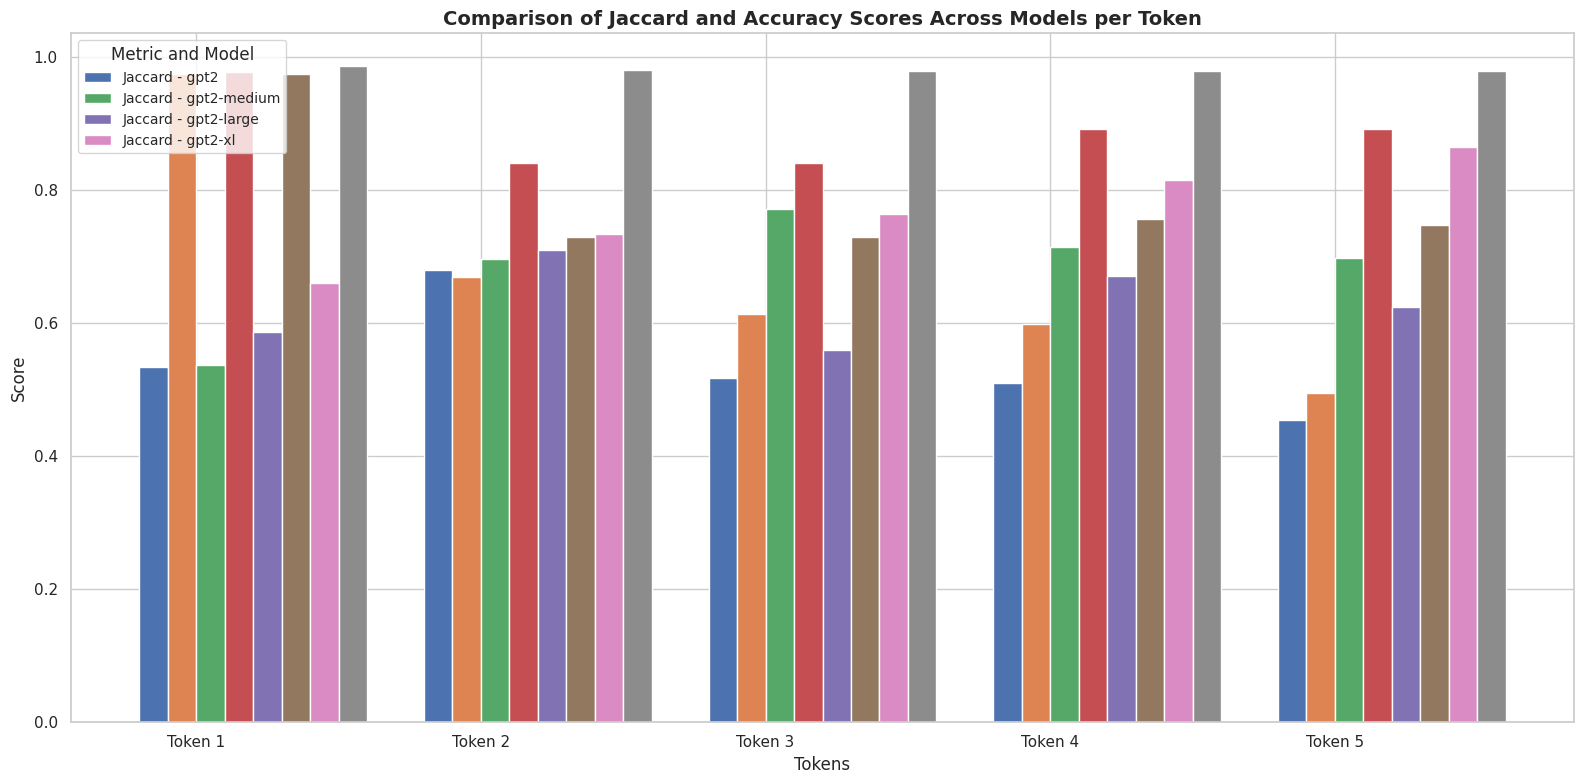

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_mean(arr):
    arr_np = np.array(arr)
    return arr_np.mean(axis=0)

def extend_lst(list1, list2):
    rtn_lst = []
    for l1, l2 in zip(list1, list2):
        rtn_lst.append(l1)
        rtn_lst.append(l2)
    return rtn_lst

# Compute mean for each model
jaccard_means = [compute_mean(jc) for jc in jc_lists]
acc_means = [compute_mean(acc) for acc in acc_lists]

# Create DataFrame for all models and metrics
data = []
tokens = np.arange(1, 6)  # Token IDs 1 to 5
for model_name, jaccard, acc in zip(model_names, jaccard_means, acc_means):
    data.append(pd.DataFrame({
        'Token': np.repeat(tokens, 2),  # Repeat each token for Jaccard and Acc
        'Metric': ['Jaccard', 'Acc'] * len(tokens),
        'Score': extend_lst(jaccard, acc),
        'Model': [model_name] * (2 * len(tokens))
    }))

# Combine into a single DataFrame
data_combined = pd.concat(data, ignore_index=True)

# Plotting
sns.set_theme(style='whitegrid')
plt.figure(figsize=(16, 8))

# Define positions and bar widths
tokens = data_combined['Token'].unique()
bar_width = 0.1
x_positions = np.arange(len(tokens))

# Create grouped bar plot
for i, model_name in enumerate(model_names):
    for j, metric in enumerate(['Jaccard', 'Acc']):
        subset = data_combined[(data_combined['Model'] == model_name) & (data_combined['Metric'] == metric)]
        plt.bar(
            x_positions + (i * 2 + j) * bar_width,  # Adjust position for model and metric
            subset['Score'],
            width=bar_width,
            label=f"{metric} - {model_name}" if j == 0 else None
        )

# Add grouping lines for tokens
plt.xticks(x_positions + 1.5 * bar_width, [f"Token {t}" for t in tokens])

# Add labels and title
plt.title('Comparison of Jaccard and Accuracy Scores Across Models per Token', fontsize=14, fontweight='bold')
plt.xlabel('Tokens', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metric and Model', loc='upper left', fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

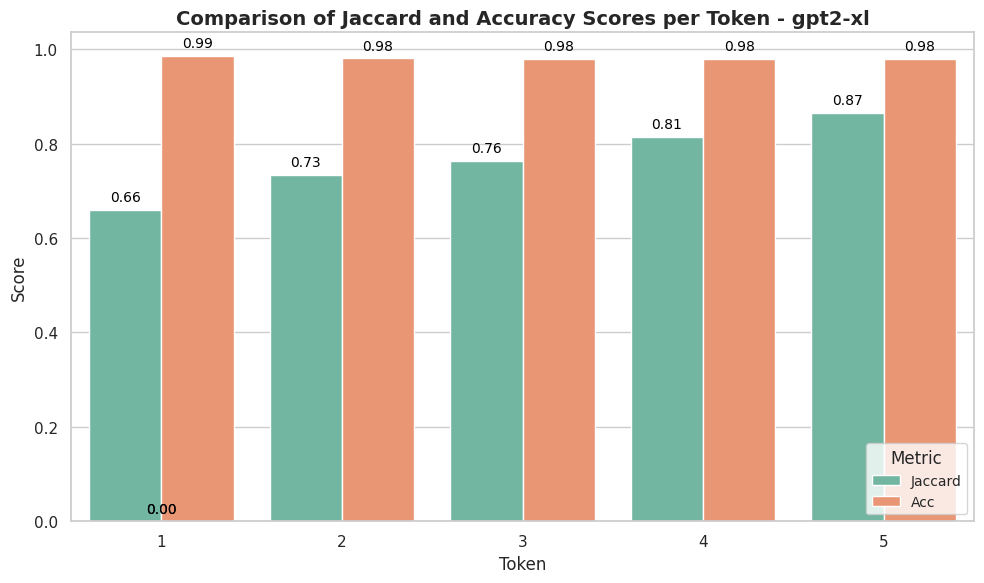

In [28]:
# GPT2-XL
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_mean(arr):
    arr_np = np.array(arr)
    return arr_np.mean(axis=0)

# Example data (replace with actual jc_ult and first_pred_ult)
jaccard = compute_mean(jc_ult)
acc = compute_mean(first_pred_ult)

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Token': np.arange(len(jaccard)) + 1,  # Token IDs starting from 1
    'Jaccard': jaccard,
    'Acc': acc
})

# Melt the DataFrame to a long format suitable for Seaborn
data_melted = data.melt(id_vars='Token', value_vars=['Jaccard', 'Acc'], 
                        var_name='Metric', value_name='Score')

# Set a modern style and define custom colors
sns.set_theme(style='whitegrid')
palette = sns.color_palette("Set2", 2)  # Define a color palette

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Token', y='Score', hue='Metric', data=data_melted, palette=palette)

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # Format to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on top of the bar
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4), textcoords='offset points')

# Add a title and labels
plt.title(f'Comparison of Jaccard and Accuracy Scores per Token - {model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Token', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Adjust legend
plt.legend(title='Metric', loc='lower right', fontsize=10, title_fontsize=12)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()
